In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

In [41]:
#Parameters
P = 1

# Generate data
M = 16
B = 1000

In [3]:
def one_hot(a, M):
    onehot = np.zeros(M)
    onehot[a] = 1
    return onehot

In [4]:
def get_norm_factor(x, P, P_M):
    return np.sum(P_M*np.abs(x)**2)

In [5]:
def awgn(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape, dtype=torch.cfloat)
    return torch.add(x, noise_t)

In [6]:
def p_norm(p, x, fun=lambda x: np.square(np.abs(x))):
    return np.sum(p * fun(x))

In [7]:
def get_norm_qam(M, P, P_M):
    r = np.arange(np.array(np.sqrt(M)))
    r = 2*(r-np.mean(r))
    r = np.meshgrid(r,r)
    constellation = np.expand_dims(np.reshape(r[0]+1j*r[1],[-1]),axis=0)
    norm_factor = np.sqrt(P/get_norm_factor(constellation, P, P_M))
    norm_constellation = norm_factor * constellation
    return norm_constellation

[[-0.9486833 -0.9486833j  -0.31622777-0.9486833j   0.31622777-0.9486833j
   0.9486833 -0.9486833j  -0.9486833 -0.31622777j -0.31622777-0.31622777j
   0.31622777-0.31622777j  0.9486833 -0.31622777j -0.9486833 +0.31622777j
  -0.31622777+0.31622777j  0.31622777+0.31622777j  0.9486833 +0.31622777j
  -0.9486833 +0.9486833j  -0.31622777+0.9486833j   0.31622777+0.9486833j
   0.9486833 +0.9486833j ]]


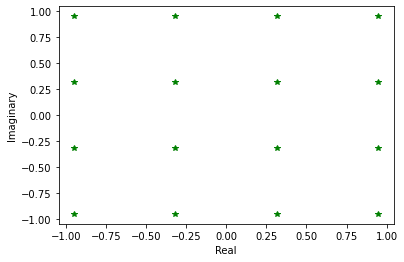

In [8]:
P_M = np.ones(1)*1/M
data = get_norm_qam(M, 1, P_M)
print(data)
x = data.real
# extract imaginary part using numpy array
y = data.imag
  
# plot the complex numbers
plt.plot(x, y, 'g*')
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

In [20]:
def sampler(P_M, B):
    samples = np.zeros((np.sum(np.rint(B*P_M).astype(int)),0))
    for idx, p in enumerate(P_M):
        occurrences = np.rint(B*p).astype(int)
        samples = np.append(samples, np.ones(occurrences)*idx)
    np.random.shuffle(samples)
    return samples.astype(int)

In [21]:
class Dist_Generator(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, M)
        self.lin1.weight = nn.Parameter(torch.full((M,M), 1/M)) # set weigths equal to uniform distribution
        
    def forward(self, y):
        return self.lin1(y)

In [22]:
class Mapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)
        
    def forward(self, y):
        return self.lin1(y)

In [23]:
class Demapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.type(torch.complex64)
        self.lin1 = nn.Linear(2, 2*M)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(2*M, 2*M)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(2*M, 2*M)
        self.act3 = nn.ReLU()
        self.lin4 = nn.Linear(2*M, 2*M)
        self.act4 = nn.ReLU()
        self.lin5 = nn.Linear(2*M, M)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        y = self.act3(self.lin3(y))
        return self.lin5(self.act4(self.lin4(y)))

In [13]:
def calculate_py_given_x(z, sigma2):
    return (1/(np.sqrt(2*np.pi*sigma2))) * np.exp(-(y-x)**2/sigma2/2) 

In [35]:
# CE loss function and correct with additional term
def custom_loss_fn(CE, logit, indices_t, zhat, sigma2):
    term_1 = CE(logit, indices_t)
    q = nn.functional.softmax(logit, 1).detach().numpy()
    term_2 = np.mean(calculate_py_given_x(zhat, sigma2)*np.log2(q))
    return term_1 + term_2

In [15]:
def complex2real(x):
    real = torch.flatten(x.real)
    imag = torch.flatten(x.imag)
    result = torch.transpose(torch.stack((real, imag)), 0, 1)
    return result

In [16]:
def plot_2D_PDF(constellation, PCS):
    fig = plt.figure()

    # syntax for 3-D projection
    #ax = plt.axes(projection ='3d')

    # defining axes
    s = PCS*100+100
    x = constellation.real
    y = constellation.imag
    #c = PCS
    plt.scatter(x, y, s, c="g")

    # syntax for plotting
    #ax.set_title('PCS')
    plt.show()

In [42]:
P = 1 # normalization parameter
SNRdBs = np.array([0, 2, 4, 6, 8, 10]) 
SNRs = 10**(SNRdBs/10)

# Initialize network
dist_generator = Dist_Generator(M)
mapper = Mapper(M)
demap = Demapper(M)
loss_fn = nn.CrossEntropyLoss()

for (k,snr) in enumerate(SNRs):
    sigma2 = P/snr
    print(f'---SNR = {SNRdBs[k]} dB---')

    # Optimizer
    optimizer = optim.Adam(list(demap.parameters()) + list(dist_generator.parameters()), lr=0.01)
    
    # Training loop
    for j in range(4001):
        # first generate the distribution
        l_M = dist_generator(torch.ones(M)).reshape(-1, M)
        P_M = nn.functional.softmax(l_M, 1).detach().numpy()[0]

        # Sample indexes
        indices = sampler(P_M, B)
        # get onehot from sampled indices
        onehot = np.array([one_hot(i, M) for i in indices])
        # convert array to tensors
        onehot_t = torch.tensor(onehot)
        indices_t = torch.tensor(indices) #labels

        # Get normalized constellation
        constellation = torch.tensor(get_norm_qam(M, P, P_M)).cfloat()
        
        xhat = torch.matmul(onehot_t.cfloat(), torch.transpose(constellation, 0, 1)) # equivalent to GCS with QAM fixed shape
        yhat = awgn(xhat, sigma2)
        l = demap(complex2real(yhat))
        loss = custom_loss_fn(loss_fn, l, indices_t, complex2real(yhat-xhat), sigma2) #handle complex
        #loss = loss_fn(l, indices_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy()/np.log(2) :.4f} dB')
        if loss < 1e-3:
            break
    # Data for the plots
    L_M = dist_generator(torch.ones(M)).reshape(-1, M)
    PCS = nn.functional.softmax(L_M, 1).detach().numpy()[0]
    constellation = get_norm_qam(M, 1, PCS)
    plot_2D_PDF(constellation, PCS)

---SNR = 0 dB---
epoch 0: Loss = 2.4085 dB
epoch 500: Loss = 0.7815 dB


KeyboardInterrupt: 